In [1]:
import math
import torch
from torch import nn
import numpy as np
from d2l import torch as d2l

In [2]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # gamma(n)=(n-1)!
# labels的维度:(n_train+n_test,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [3]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[ 0.3497],
         [-0.2509]]),
 tensor([[ 1.0000e+00,  3.4973e-01,  6.1154e-02,  7.1291e-03,  6.2331e-04,
           4.3597e-05,  2.5412e-06,  1.2696e-07,  5.5502e-09,  2.1567e-10,
           7.5426e-12,  2.3980e-13,  6.9888e-15,  1.8801e-16,  4.6967e-18,
           1.0950e-19,  2.3935e-21,  4.9240e-23,  9.5669e-25,  1.7609e-26],
         [ 1.0000e+00, -2.5091e-01,  3.1478e-02, -2.6327e-03,  1.6514e-04,
          -8.2872e-06,  3.4656e-07, -1.2422e-08,  3.8960e-10, -1.0862e-11,
           2.7253e-13, -6.2164e-15,  1.2998e-16, -2.5087e-18,  4.4961e-20,
          -7.5208e-22,  1.1794e-23, -1.7407e-25,  2.4265e-27, -3.2043e-29]]),
 tensor([5.1993, 4.4716]))

In [4]:
def evaluate_loss(net, data_iter, loss):  #@save
    """评估给定数据集上模型的损失"""
    metric = d2l.Accumulator(2)  # 损失的总和,样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [5]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[ 4.9749002  1.2284358 -3.3778603  5.5290594]]


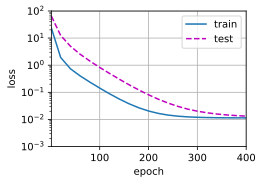

In [6]:
# 从多项式特征中选择前4个维度，即1,x,x^2/2!,x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[3.2860706 3.3272614]]


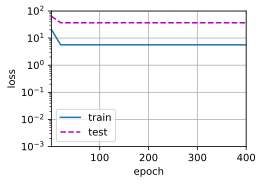

In [7]:
# 从多项式特征中选择前2个维度，即1和x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[ 4.9563017   1.2877198  -3.2708187   5.1132803  -0.3629404   1.5253457
   0.12078641  0.32938367  0.03132584  0.0396501  -0.08125951  0.04356237
  -0.13466646  0.03469145 -0.01998797 -0.2184438  -0.11725069  0.1252012
   0.21952671 -0.19370854]]


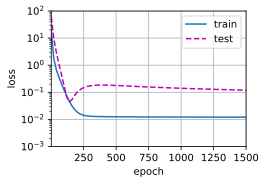

In [8]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)